In [1]:
!git clone https://github.com/amirhosein-mesbah/AMAlearn.git

Cloning into 'AMAlearn'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 33 (delta 2), reused 33 (delta 2), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [2]:
!ls

AMAlearn  sample_data


In [3]:
%cd '/content/AMAlearn/'

/content/AMAlearn


In [4]:
!pwd

/content/AMAlearn


In [5]:
!pip install -e .

Obtaining file:///content/AMAlearn
  Running setup.py develop for amalearn


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from amalearn.environment import MutliArmedBanditEnvironment
from amalearn.agent import RandomBanditAgent
from amalearn.reward import GaussianReward
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reward

In [9]:
class ProbReward(RewardBase):
    def __init__(self, mean, std , low, up, p):
        super(ProbReward, self).__init__()
        self.mean = mean
        self.std = std
        self.low = low
        self.up = up
        self.p = p

    def get_reward(self):
        dist = [np.random.normal(loc=self.mean, scale=self.std), np.random.uniform(self.low,self.up)]
        return np.random.choice(dist, 1, p=[self.p, (1-self.p)])[0]


In [10]:
mean_4 = 3
std_4 = 2
down = -3
up = 1
p = 0.7


In [11]:
rewards = []
means = [5, 3, 2]
stds = [1, 2, 1]
rewards = [GaussianReward(means[i] , stds[i]) for i in range(len(means))]
rewards.append(ProbReward(mean_4, std_4, down, up, p))

# Utility **function**

In [13]:
def utility(r , alpha , beta , landa):
  if r>0:
    result = np.power(r,alpha)
  else:
    result = -landa*np.power(np.abs(r),beta)
  return  result

## **Agents**

In [12]:
num_trials = 1000
num_actions = 4
eps = 0.2
lr = 0.2
delta = 0.2

In [ ]:
class Agent_epsilonGreedy(AgentBase):
    def __init__(self, id, environment, eps, lr):
        super(Agent_epsilonGreedy, self).__init__(id, environment)
        
        self.lr = lr
        self.eps = eps
        self.available_actions = environment.available_actions()
        self.action_counts = [0 for i in range(self.available_actions)]
        self.QValues = [0 for i in range(self.available_actions)] 
    def select_action(self):

        policy = [np.argmax(self.QValues), np.random.randint(0, self.available_actions) ]
        action = np.random.choice(policy, 1, p=[self.eps, (1-self.eps)])
        return action[0]

    def update(self, action, r):

        self.action_counts[action] += 1
        self.QValues[action] = self.QValues[action] + self.lr * (r-self.QValues[action])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, Ri, d, i = self.environment.step(action)
        self.update(action, Ri)
        #self.environment.render()
        return obs, Ri, d, i, action

In [ ]:
env = MutliArmedBanditEnvironment(rewards, 1000, '1')

In [ ]:
def eps_run(env,alpha,beta,landa ):

  mean_reward = []

  for epoch in range(20):
    reward = []
    agent = Agent_epsilonGreedy('1',env,0.2,1)
    env.reset()
    for i in range(1000):
      _,r,_,_,action = agent.take_action()
      agent.lr = agent.lr/(i+1)
      reward.append(utility(r,alpha,beta,landa))
    mean_reward.append(reward)
  return np.mean(mean_reward,axis = 0),action

epsilon-greedy acton:  1


Text(0.5, 1.0, 'Epsilon Greedy')

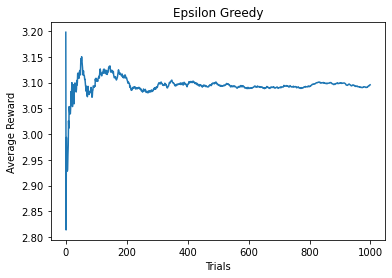

In [ ]:
a ,action = eps_run(env,1,1,1)
a = np.cumsum(a)
print("epsilon-greedy acton: ",action)
for i in range(len(a)):
  a[i] = a[i]/(i+1)
plt.plot(a)
plt.xlabel('Trials')
plt.ylabel('Average Reward')
plt.title('Epsilon Greedy')

In [ ]:
class Agent_UCB(AgentBase):
    def __init__(self, id, environment, delta):
        super(Agent_UCB, self).__init__(id, environment)
        self.rewards_means = []
        self.delta = delta
        self.available_actions = self.environment.available_actions()
        self.action_counts = [0 for i in range(self.available_actions)]
        self.C = 1
        self.lr = 1
        self.rewards_means = [1000 for _ in range(self.available_actions)]

    def select_action(self):

        UCB = []
        for i in range(self.available_actions):
            mean = self.rewards_means[i]
            ucb = self.rewards_means[i] + self.C * np.sqrt(2 * np.log(1 / self.delta) / self.action_counts[i])
            UCB.append(ucb)
       
        action = np.argmax(np.array(UCB))
        return action

    def update(self, action, r):
        self.action_counts[action] += 1
        self.lr = (1 / self.action_counts[action])
        self.rewards_means[action] = self.rewards_means[action] + self.lr* (r - self.rewards_means[action])

    def take_action(self) -> (object, float, bool, object):
        action = self.select_action()
        obs, Ri, d, i = self.environment.step(action)
        self.update(action, Ri)
        #self.environment.render()
        return obs, Ri, d, i, action

In [ ]:
env_ucb = MutliArmedBanditEnvironment(rewards, 1000, '2')

In [ ]:
def ucb_run(env ,alpha , beta , landa):

  mean_reward = []
  for epoch in range(20):
    reward = []
    delta = 1
    agent = Agent_UCB('2',env_ucb ,delta)
    env.reset()
    for i in range(1000):
      _,r,_,_,action = agent.take_action()
      agent.delta = 1/(i+1)
      reward.append(utility(r,alpha,beta,landa))
    mean_reward.append(reward)
  return np.mean(mean_reward,axis = 0),action

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


ucb-action 0


Text(0.5, 1.0, 'UCB Agent')

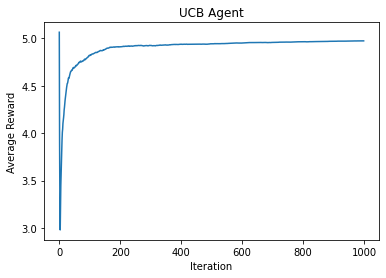

In [ ]:
b,action_ucb = ucb_run(env_ucb , 1 , 1 , 1)
b = np.cumsum(b)
print("ucb-action",action_ucb)
for i in range(len(b)):
  b[i] = b[i]/(i+1)
plt.plot(b);
plt.ylabel('Average Reward')
plt.xlabel('Iteration')
plt.title('UCB Agent')

In [ ]:
"""class UCBAgent(AgentBase):
    def __init__(self, id, environment, delta):
        super(UCBAgent, self).__init__(id, environment)
        self.rewards_means = []
        self.delta = delta
        self.available_actions = environment.available_actions()
        self.action_counts = [0 for i in range (self.available_actions)]
        self.C = 1
        
        self.rewards_means = [0 for _ in range(self.availabel_actions)]

        
    def take_action(self):
        UCB = []
        for i in range(self.available_actions):
            mean = self.rewards_means[i]
            ucb = self.rewards_means[i] + self.C * np.sqrt(2 * np.log(1 / self.delta) / self.action_counts[i])
            UCB.append(ucb)
       
        action = np.argmax(np.array(UCB))
        obs, r, d, i = self.environment.step(action)
        self.action_counts[action] += 1
        self.rewards_means[action] = self.rewards_means[action] + (1 / self.action_counts[action])* (r - self.rewards_means[action])
            
        return obs, r, d, i, action"""

In [ ]:
class GradientAgent(AgentBase):
    def __init__(self, id, environment, alpha):
        super(GradientAgent, self).__init__(id, environment)
        self.available_actions = self.environment.available_actions()
        self.action_counts = [0]*self.available_actions
        self.H = [0.0]*self.available_actions
        self.policy = [1/self.available_actions]*self.available_actions
        self.actions = list(range(self.available_actions))
        self.mean_reward = 0.0
        self.alpha = alpha
        self.total_actions_count = 0
        
    def take_action(self):
        action = np.random.choice(self.actions, 1, p=self.policy)[0]
        obs, r, d, i = self.environment.step(action)
        for a in self.actions:
            if a == action:
                self.H[a] = self.H[a] + self.alpha*(r-self.mean_reward)*(1-self.policy[a])
            else:
                self.H[a] = self.H[a] - self.alpha*(r-self.mean_reward)*(self.policy[a])
        for i in range(len(self.policy)):
            self.policy[i] = np.exp(self.H[i])/np.sum(np.exp(self.H))
            self.total_actions_count += 1
        self.mean_reward = (self.mean_reward*(self.total_actions_count-1)+r)/self.total_actions_count
        
        self.action_counts[action] += 1
        return obs, r, d, i, action

In [ ]:
env_g = MutliArmedBanditEnvironment(rewards, num_trials, '3')

In [ ]:
def gradient_run(env,alpha,beta,landa):

  mean_reward = []

  for epoch in range(20):
    reward = []
    agent = GradientAgent('1',env,1)
    env.reset()
    for i in range(1000):
      _,r,_,_,action = agent.take_action()
      reward.append(utility(r,alpha,beta,landa))
    mean_reward.append(reward)
  return np.mean(mean_reward,axis = 0),action

gradient-action: 0


Text(0.5, 1.0, 'Gradient Agent')

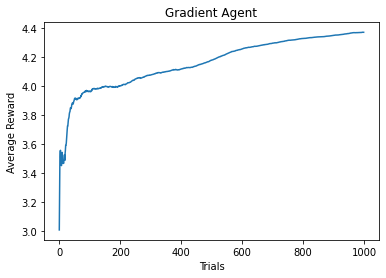

In [ ]:
c,g_action = gradient_run(env_g,1,1,1)
c = np.cumsum(c)
print("gradient-action:",g_action)
for i in range(len(c)):
  c[i] = c[i]/(i+1)
plt.plot(c);
plt.ylabel('Average Reward')
plt.xlabel('Trials')
plt.title('Gradient Agent')

Text(0.5, 1.0, 'Comparison')

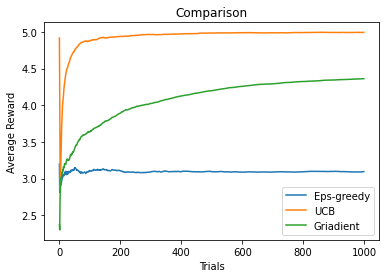

In [ ]:
plt.plot(a)
plt.plot(b)
plt.plot(c);
plt.legend(['Eps-greedy','UCB','Griadient'])
plt.ylabel('Average Reward')
plt.xlabel('Trials')
plt.title('Comparison')

بخش **ب**

gradient agent

In [ ]:
def gradient_utility(u_parameter,parameter):
  u_gradient = []
  if parameter == 'alpha':
    for i in u_parameter :
      u, action = gradient_run(env_g,i,1,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_gradient.append(u)
  if parameter == 'beta':
    for i in u_parameter :
      u, action = gradient_run(env_g,1,i,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_gradient.append(u)
  if parameter == 'landa':
    for i in u_parameter :
      u,action = gradient_run(env_g,1,1,i)
      print("action:" , action)
      u = np.cumsum(u)
      u_gradient.append(u)

  for u in u_gradient:
      for i in range(len(u)):
        u[i] = u[i]/(i+1)
  for i in range(len(u_gradient)):
    plt.plot(u_gradient[i])
  plt.legend([str(i) for i in u_parameter])
  plt.ylim(ymin=0)
  plt.ylabel('Average Reward')
  plt.xlabel('Trials')

action: 0


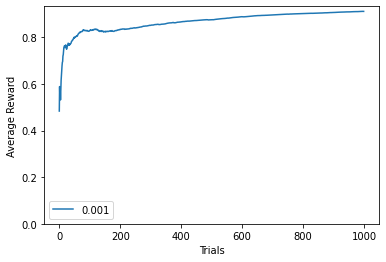

In [ ]:
#alpha
gradient_utility([0.001],'alpha')

action: 0


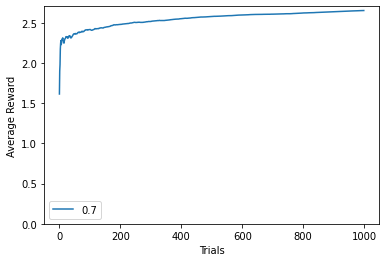

In [ ]:
gradient_utility([0.7],'alpha')

action: 0


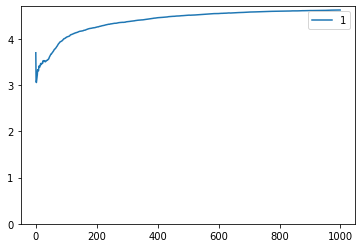

In [ ]:
gradient_utility([1],'alpha')

action: 1


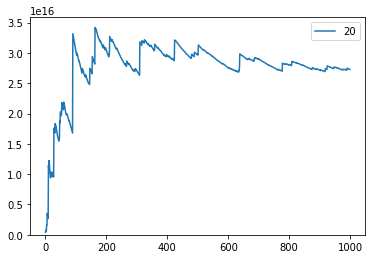

In [ ]:
gradient_utility([20],'alpha')

action: 0
action: 0
action: 0
action: 1
action: 0


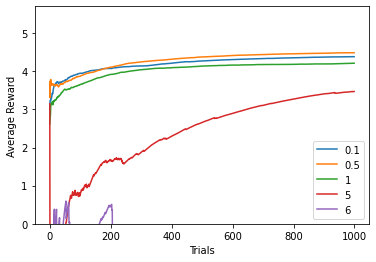

In [ ]:
#beta
gradient_utility([0.1,0.5,1,5,6],'beta')

action: 0
action: 0
action: 0
action: 2
action: 1
action: 0


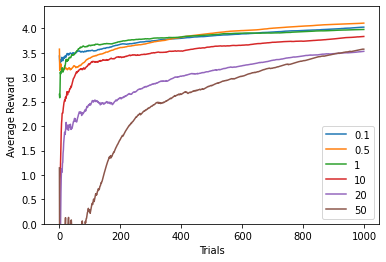

In [ ]:
#landa
gradient_utility([0.1,0.5,1,10,20,50],'landa')

action: 1


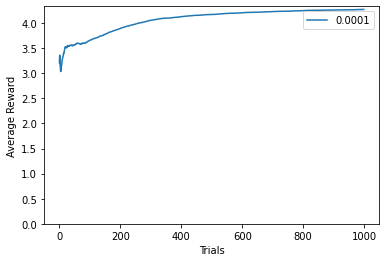

In [ ]:
#landa
gradient_utility([0.0001],'landa')

In [ ]:
def ucb_utility(u_parameter,parameter):
  u_ucb = []
  if parameter == 'alpha':
    for i in u_parameter :
      u, action = ucb_run(env_ucb,i,1,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_ucb.append(u)
  if parameter == 'beta':
    for i in u_parameter :
      u, action = ucb_run(env_ucb,1,i,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_ucb.append(u)
  if parameter == 'landa':
    for i in u_parameter :
      u,action = ucb_run(env_ucb,1,1,i)
      print("action:" , action)
      u = np.cumsum(u)
      u_ucb.append(u)

  for u in u_ucb:
      for i in range(len(u)):
        u[i] = u[i]/(i+1)
  for i in range(len(u_ucb)):
    plt.plot(u_ucb[i])
  plt.legend([str(i) for i in u_parameter])
  plt.ylim(ymin=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


action: 0


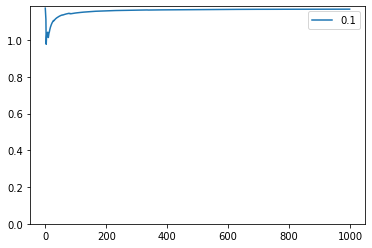

In [ ]:
#alpha
ucb_utility([0.1],'alpha')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


action: 0


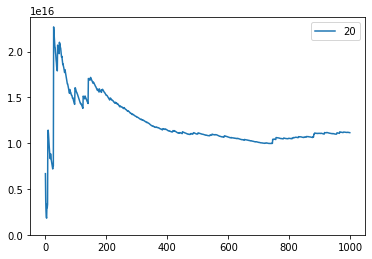

In [ ]:
#alpha
ucb_utility([20],'alpha')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


action: 0
action: 0
action: 0
action: 0
action: 0


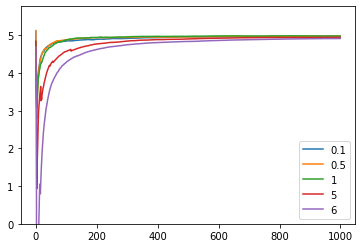

In [ ]:
#beta
ucb_utility([0.1,0.5,1,5,6],'beta')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


action: 0


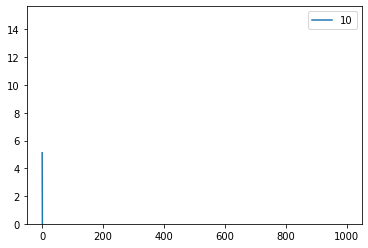

In [ ]:
#beta
ucb_utility([10],'beta')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


action: 0
action: 0
action: 0
action: 0
action: 0


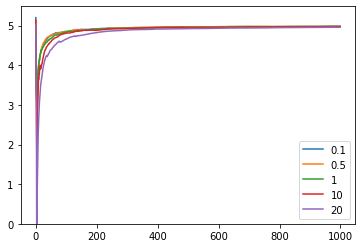

In [ ]:
#landa
ucb_utility([0.1,0.5,1,10,20],'landa')

In [ ]:
def eps_utility(u_parameter,parameter):
  u_eps = []
  if parameter == 'alpha':
    for i in u_parameter :
      u, action = eps_run(env_g,i,1,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_eps.append(u)
  if parameter == 'beta':
    for i in u_parameter :
      u, action = eps_run(env_g,1,i,1)
      print("action:" , action)
      u = np.cumsum(u)
      u_eps.append(u)
  if parameter == 'landa':
    for i in u_parameter :
      u,action = eps_run(env_g,1,1,i)
      print("action:" , action)
      u = np.cumsum(u)
      u_eps.append(u)

  for u in u_eps:
      for i in range(len(u)):
        u[i] = u[i]/(i+1)
  for i in range(len(u_eps)):
    plt.plot(u_eps[i])
  plt.legend([str(i) for i in u_parameter])
  plt.ylim(ymin=0)


action: 2


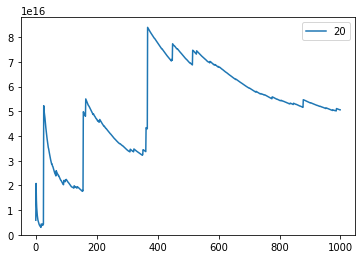

In [ ]:
#alpha
eps_utility([20],'alpha')

action: 2


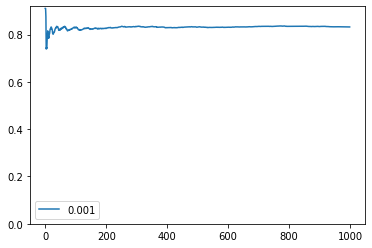

In [ ]:
#alpha
eps_utility([0.001],'alpha')

action: 3
action: 0
action: 0
action: 1
action: 3


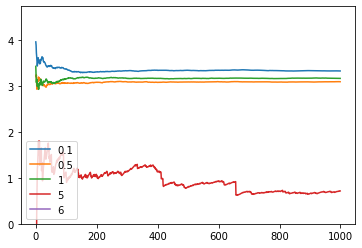

In [ ]:
#beta
eps_utility([0.1,0.5,1,5,6],'beta')

action: 0
action: 2
action: 2
action: 1
action: 2


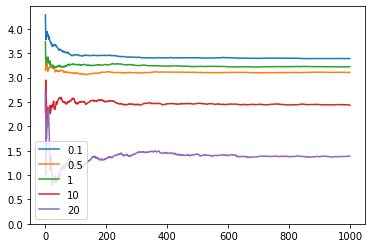

In [ ]:
#landa
eps_utility([0.1,0.5,1,10,20],'landa')